#Install pytorch & import

In [1]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [2]:
from math import sqrt
import numpy as np
from scipy import linalg
import scipy.sparse.linalg as splinalg

from time import time
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader,TensorDataset
print(torch.__version__)
device = torch.device('cpu')

0.4.1


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    torch.cuda.empty_cache()

Tesla K80
0
0


# Define the unrolled ISTA (uISTA)

In [0]:
class uISTA(torch.nn.Module):

    def __init__(self, num_unroll, A, l=1., scale=1., prox=None):
        super(uISTA, self).__init__()
        self.num_unroll = num_unroll
        self.A = torch.nn.Parameter(torch.FloatTensor(A), requires_grad=True)
        self.l = torch.nn.Parameter(torch.FloatTensor([l]), requires_grad=True)
        self.scale = scale
        if prox is None:
            self.prox = lambda z, th: z.sign() * (z.abs_() - th).max(torch.tensor(0, device=device).float())
        else:
            self.prox = prox
            
    def forward(self, b):
        theta = torch.mul(self.l, self.scale)
        # prox(A.dot(b*scale), theta) for initial guess of x
        x = self.prox(b.mul(self.scale).matmul(self.A), theta)
        for i in range(self.num_unroll):
            # x = prox(x+A.T.dot(b-A.dot(x))*scale, theta)
            x = self.prox(x + (b - x.matmul(self.A.t())).mul_(self.scale).matmul(self.A), theta)
        return x

#Prepare dataset

In [0]:
n_samples = 400

# generate sythetic data for demo
rng = np.random.RandomState(int(time()))
#m, n = 512, 2048
m, n = 256,1024
#m, n = 2000, 4000

# use a random matrix as a basis (design matrix)
A = rng.randn(m, n) / np.sqrt(m)

# generate k-sparse Gaussian signal vectors
k = 50
stdx = 1.
snr = 10.
support_range = np.arange(0, max(int(n/4), k))

input_data = np.zeros((n_samples, m))
output_data = np.zeros((n_samples, n))
for i in range(n_samples) :

    x_true = np.zeros(n,dtype=np.float32)
    T = rng.choice(len(support_range), k, replace=False)
    x_true[support_range[T]] = rng.randn(k) * stdx

    # make the query vector
    b = A.dot(x_true)

    # add noise
    normb = linalg.norm(b)
    noise = rng.randn(m)
    noise = noise / linalg.norm(noise) * normb / snr
    b = b + noise
  
    input_data[i, :] = b
    output_data[i, :] = x_true

In [0]:
n_train = min(300, n_samples)
from sklearn.model_selection import train_test_split
input_train, input_test, output_train, output_test = train_test_split(input_data, output_data, test_size=n_train)

#Demonstrate ISTA with numpy

In [0]:
# soft thresholding function
def soft(z, th):
    return np.sign(z) * np.maximum(np.abs(z) - th, 0)

from scipy import linalg
# Iterative soft thresholding (IST)
def ISTA(A, b, tol=1e-5, maxiter=300, l=1., L=None):
    m, n = A.shape
    x = np.zeros(n)
    r = b.copy()
    if L is None:    # roughly estimate the Lipschitz constant
        L = 2*linalg.norm(A.dot(A.T.dot(b))) / linalg.norm(b)
    count = 0
    cost_history = []
    normr = linalg.norm(r)
    while count < maxiter and normr > tol:
        count += 1
        x = soft(x + A.T.dot(r) / L, l/L)
        r = b - A.dot(x)
        normr = linalg.norm(r)
        cost_history.append( normr*normr + l*np.sum(np.abs(x)) )
    return x, cost_history


done 100 steps in 27.81ms by numpy
2.7198335199527506


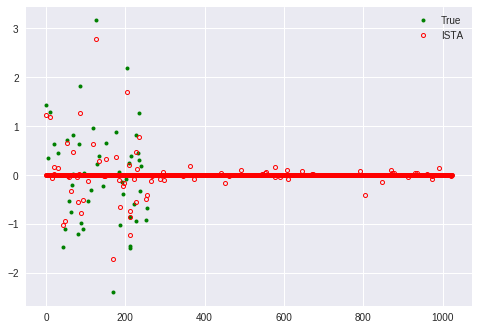

In [8]:
# pick up a test sample, and show the estimate
b = input_test[0,:]
x_true = output_test[0,:]

l = 1.*(stdx*stdx / k * m) / np.sqrt(snr) / normb
L = 2*linalg.norm(A.dot(A.T.dot(b))) / linalg.norm(b)
maxit = 100

t0 = time()
x_est = ISTA(A, b, maxiter=maxit, l=l, L=L)[0]
print('done %d steps in %.2fms by numpy' % (maxit, (time() - t0)*1000))

print(np.linalg.norm(x_true-x_est))
import matplotlib.pyplot as plt
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=4, mec='red', mew=1, label='ISTA')
plt.legend(loc='upper right', shadow=False)
plt.show()

#Instantiate uISTA model & check initial performance

In [0]:
# soft shrinkage function with learnable lambda
def softshrink(z,th):
    #return torch.sign(z) * torch.max(torch.sub(torch.abs(z),th), torch.zeros_like(z))
    return z.sign() * (z.abs() - th).max(torch.tensor(0, device=device).float())


In [10]:
n_layers_unroll  = 20

#l_ini = l
l_ini = np.ones(n) * l

#model = uISTA(n_layers_unroll, A, l=l_ini, scale=1./L, prox=lambda z,th: softshrink(z,th)).to(device)
model = uISTA(n_layers_unroll, A, l=l_ini, scale=1./L).to(device=device)

print('Is model parameters on GPU? :', next(model.parameters()).is_cuda)
for param in model.parameters():
    print(type(param.data), param.size(), ', is_cuda:', param.is_cuda)

Is model parameters on GPU? : True
<class 'torch.Tensor'> torch.Size([256, 1024]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1024]) , is_cuda: True


done fwd. prop. of 20 layers in 18.65ms
4.826395173040884
2.7198335199527506


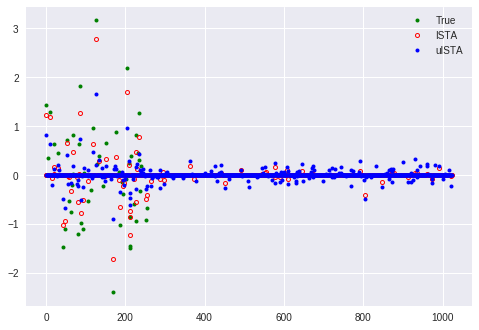

In [11]:
b_torch = torch.from_numpy(b).float().to(device)
t0 = time()
with torch.no_grad():
    model_out = model(b_torch)
print('done fwd. prop. of %d layers in %.2fms' % (model.num_unroll, (time() - t0)*1000))

x_uista = model_out.detach().cpu().numpy().ravel()
print(np.linalg.norm(x_uista-x_true))
print(np.linalg.norm(x_est-x_true))
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=4, mec='red', mew=1, label='ISTA')
plt.plot(np.arange(n), x_uista, 'b.', markersize=8, mec='green', label='uISTA')
plt.legend(loc='upper right', shadow=False)
plt.show()

#Optimize the model

In [0]:
batch_size = 10

#train_set = TensorDataset(torch.from_numpy(input_train).float(), torch.from_numpy(output_train).float())
train_set = TensorDataset(torch.from_numpy(input_train).float().to(device), torch.from_numpy(output_train).float().to(device))
data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)


# define loss and optimizer
criterion = torch.nn.MSELoss().to(device)

optimizer, optimizer_l, optimizer_A = None, None, None
del optimizer, optimizer_l, optimizer_A

optimizer = torch.optim.Adam(model.parameters(), lr = 0.00003 * sqrt(batch_size))

#optimizer = torch.optim.RMSprop([model.A, model.l], lr = 0.00003 * sqrt(batch_size))
#optimizer_l = torch.optim.Adam([model.l], lr = 0.03)
#optimizer_A = torch.optim.Adam([model.A], lr= 0.001)

In [13]:
#training
num_epochs = 100
display_step = 10

t0 = time()
for epoch in range(num_epochs):
    running_loss = 0.

    for data_in, data_out in data_loader:

        # Forward pass
        model_out = model(data_in)
        loss = criterion(model_out, data_out)

        # Backward and optimize
        if 'optimizer' in locals():
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            running_loss += loss.item()

        if 'optimizer_A' in locals():
            optimizer_A.zero_grad()
            loss.backward(retain_graph=True)
            optimizer_A.step()
            running_loss += loss.item()

        if 'optimizer_l' in locals():
            optimizer_l.zero_grad()
            loss.backward(retain_graph=True)
            optimizer_l.step()
            running_loss += loss.item()
         
    if (epoch+1) % display_step == 0:
        print ('Epoch [{:3d}/{}]: loss = {:.4f},  '.format(epoch+1, num_epochs, running_loss), end='')
        print('l in [{:.4f}, {:.4f}]'.format(model.l.min(), model.l.max()))

print('done in %.2fs' % (time() - t0))
if torch.cuda.is_available():
    print(torch.cuda.memory_allocated(), ' / ', torch.cuda.max_memory_allocated())
    print(torch.cuda.memory_cached(), ' / ', torch.cuda.max_memory_cached())
    #torch.cuda.empty_cache()

Epoch [ 10/100]: loss = 0.1616,  l in [0.2309, 0.2466]
Epoch [ 20/100]: loss = 0.1276,  l in [0.2249, 0.2536]
Epoch [ 30/100]: loss = 0.1079,  l in [0.2195, 0.2594]
Epoch [ 40/100]: loss = 0.0960,  l in [0.2145, 0.2644]
Epoch [ 50/100]: loss = 0.0881,  l in [0.2096, 0.2689]
Epoch [ 60/100]: loss = 0.0823,  l in [0.2047, 0.2726]
Epoch [ 70/100]: loss = 0.0778,  l in [0.1999, 0.2754]
Epoch [ 80/100]: loss = 0.0741,  l in [0.1951, 0.2782]
Epoch [ 90/100]: loss = 0.0708,  l in [0.1902, 0.2810]
Epoch [100/100]: loss = 0.0679,  l in [0.1853, 0.2834]
done in 39.10s
9302016  /  13914624
17825792  /  17825792


done fwd. prop. of 20 layers in 16.65ms
4.194648371165114
2.7198335199527506


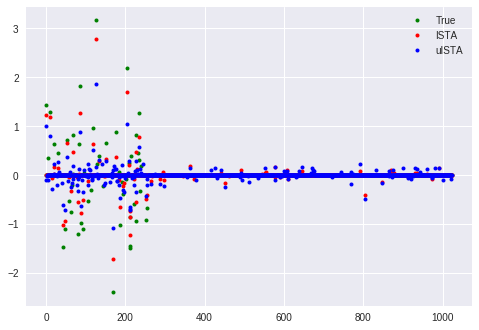

In [14]:
#model.cpu()
b_torch = torch.from_numpy(b).float().to(device)
t0 = time()
with torch.no_grad():
    model_out = model(b_torch)
print('done fwd. prop. of %d layers in %.2fms' % (model.num_unroll, (time() - t0)*1000))

x_uista = model_out.detach().cpu().numpy().ravel()
print(np.linalg.norm(x_uista-x_true))
print(np.linalg.norm(x_est-x_true))
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'r.', markersize=8, mec='red', label='ISTA')
plt.plot(np.arange(n), x_uista, 'b.', markersize=8, mec='blue', label='uISTA')
#plt.plot(np.arange(n),output_init.detach().cpu().numpy(), 'bo', mfc = 'None', markersize=8, mec='blue', mew=1, label='LISTA')
plt.legend(loc='upper right', shadow=False)
plt.show()

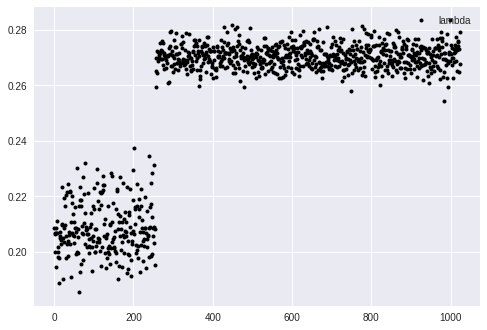

In [15]:
plt.plot(np.arange(n), model.l.detach().cpu().numpy().ravel(), 'k.', markersize=8, mec='k', label='lambda')
plt.legend(loc='upper right', shadow=False)